In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

complaint_compile_report_june = pd.read_csv("complaint_compile_report_jun_2024.csv")

In [ ]:
from sklearn.model_selection import train_test_split
df,test = train_test_split(complaint_compile_report_june, test_size=0.3, random_state=42)

The following is info gathered from meetings to determine Truckroll Y/N, not yet verified

In [ ]:
def check_truckroll(row):
    if row['ANALYSIS'] == 'Outage':
        return 'N'
    elif row['Team'] == 'THD':
        return 'N'
    elif row['Appt Y/N'] == 'Y' and row['ANALYSIS'] == 'CBI' and row['Team'] != 'THD':
        return 'N'
    elif row['Appt Y/N'] == 'Y' and row['ANALYSIS'] != 'CBI' and row['Team'] != 'THD':
        return 'Y'
    else:
        return 'Y'
# Apply the function to each row
test['Truckroll Y/N'] = test.apply(check_truckroll, axis=1)

In [ ]:
test_result = test['Truckroll Y/N']

from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
test_result = lb.fit_transform(test_result)
test_result = test_result.ravel()

In [ ]:
df[['Fault Group', 'Fault Specific']] = df['Fault'].str.split('-', expand=True)


In [ ]:
def check_truckroll(row):
    if row['ANALYSIS'] == 'Outage':
        return 'N'
    elif row['Team'] == 'THD':
        return 'N'
    elif row['Appt Y/N'] == 'Y' and row['ANALYSIS'] == 'CBI' and row['Team'] != 'THD':
        return 'N'
    elif row['Appt Y/N'] == 'Y' and row['ANALYSIS'] != 'CBI' and row['Team'] != 'THD':
        return 'Y'
    else:
        return 'Y'
# Apply the function to each row
df['Truckroll Y/N'] = df.apply(check_truckroll, axis=1)

In [ ]:
df_selected = df[['Type','Priority','Zone','Speed Profile','ISP','Truckroll Y/N','Fault Group','Fault Specific']]

In [ ]:
df_selected.shape

(105338, 8)

In [ ]:
null_counts = df_selected.isnull().sum()
print(null_counts)

Type                  0
Priority          35038
Zone                  0
Speed Profile       303
ISP                   0
Truckroll Y/N         0
Fault Group           0
Fault Specific    12901
dtype: int64


In [ ]:
df_cleaned = df_selected.fillna("Missing")


In [ ]:
df_cleaned.shape

(105338, 8)

In [ ]:
X = df_cleaned.drop(['Truckroll Y/N'], axis=1)
y = df_cleaned['Truckroll Y/N']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [ ]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_train = y_train.ravel()
y_test = lb.transform(y_test)
y_test = y_test.ravel()

In [ ]:
y_train

array([1, 1, 1, ..., 1, 0, 1])

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')

# Select columns to encode
columns_to_encode = ['Type','Priority','Zone','Speed Profile','ISP','Fault Specific','Fault Group']

# Fit and transform the encoder on the selected columns
encoded_array_train_X = encoder.fit_transform(X_train[columns_to_encode])
encoded_array_test_X = encoder.transform(X_test[columns_to_encode])

# Retrieve the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(columns_to_encode)

# Create a DataFrame with the encoded features
encoded_df_train_X = pd.DataFrame(encoded_array_train_X, columns=encoded_feature_names)
encoded_df_test_X = pd.DataFrame(encoded_array_test_X, columns=encoded_feature_names)

# Optionally, drop the original categorical columns and concatenate the encoded columns
X_train = pd.concat([X_train.reset_index(drop=True), encoded_df_train_X.reset_index(drop=True)], axis=1)
X_test = pd.concat([X_test.reset_index(drop=True), encoded_df_test_X.reset_index(drop=True)], axis=1)

X_train.drop(columns=columns_to_encode, inplace=True)
X_test.drop(columns=columns_to_encode, inplace=True)

In [ ]:
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import optuna

def objective(trial):
    model = trial.suggest_categorical('classifier', ['XGBClassifier', 'LightGBM', 'CatBoostClassifier', 'SVM'])

    if model == 'XGBClassifier':
        parameters = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 1500),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1), 
            "max_depth": trial.suggest_int("max_depth", 3, 10), 
            "subsample": trial.suggest_float("subsample", 0.7, 1.0),  
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.7, 1.0), 
            "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        }
        classifier = XGBClassifier(**parameters)

    elif model == 'LightGBM':
        parameters = {
            'objective': 'binary',
            'metric': 'binary_error',
            'verbosity': -1,
            'boosting_type': 'gbdt',
            'n_estimators': trial.suggest_int('n_estimators', 100, 3000),
            'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.1),
            'max_depth': trial.suggest_int('max_depth', 3, 10),
            'subsample': trial.suggest_float('subsample', 0.7, 1.0),
            'colsample_bytree': trial.suggest_float('colsample_bytree', 0.7, 1.0),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
            'num_leaves': trial.suggest_int('num_leaves', 10, 1000)  
        }
        classifier = LGBMClassifier(**parameters)

    elif model == 'CatBoostClassifier':
        parameters = {
            "n_estimators": trial.suggest_int("n_estimators", 100, 2000),
            "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.1),
            "depth": trial.suggest_int("depth", 3, 10),
            "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-3, 1e3, log=True),
        }
        classifier = CatBoostClassifier(**parameters, verbose=False)
    
    elif model == 'SVM':
        parameters = {
            'C': trial.suggest_float('C', 1e-3, 1e2, log=True),
            'kernel': trial.suggest_categorical('kernel', ['linear', 'poly', 'rbf', 'sigmoid']),
            'gamma': trial.suggest_categorical('gamma', ['scale', 'auto'])
        }
        classifier = SVC(**parameters)

    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Create and optimize the study
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=3, n_jobs=1)

# Print the best parameters
best_params = study.best_params
print("Best parameters:", best_params)
print("Best classifier:", best_params['classifier'])


[I 2024-07-31 16:49:05,533] A new study created in memory with name: no-name-0a92c924-729d-4a81-8b9d-033b82607a90
[I 2024-07-31 16:49:24,482] Trial 0 finished with value: 0.8164989557622935 and parameters: {'classifier': 'CatBoostClassifier', 'n_estimators': 818, 'learning_rate': 0.058189437773111134, 'depth': 9, 'l2_leaf_reg': 672.3954897935702}. Best is trial 0 with value: 0.8164989557622935.
[I 2024-07-31 16:49:29,918] Trial 1 finished with value: 0.8158344408581736 and parameters: {'classifier': 'CatBoostClassifier', 'n_estimators': 415, 'learning_rate': 0.041045164789951814, 'depth': 4, 'l2_leaf_reg': 0.0033924197181336457}. Best is trial 0 with value: 0.8164989557622935.
[I 2024-07-31 16:49:48,552] Trial 2 finished with value: 0.8160243022593506 and parameters: {'classifier': 'CatBoostClassifier', 'n_estimators': 1633, 'learning_rate': 0.0498197363767809, 'depth': 3, 'l2_leaf_reg': 124.2880962713597}. Best is trial 0 with value: 0.8164989557622935.


Best parameters: {'classifier': 'CatBoostClassifier', 'n_estimators': 818, 'learning_rate': 0.058189437773111134, 'depth': 9, 'l2_leaf_reg': 672.3954897935702}
Best classifier: CatBoostClassifier


In [ ]:
print(best_params) 


{'classifier': 'CatBoostClassifier', 'n_estimators': 818, 'learning_rate': 0.058189437773111134, 'depth': 9, 'l2_leaf_reg': 672.3954897935702}


In [ ]:
best_classifier_type = best_params['classifier']

if best_classifier_type == 'XGBClassifier':
    best_params.pop('classifier')
    best_model = XGBClassifier(**best_params)
elif best_classifier_type == 'LightGBM':
    best_params.pop('classifier')
    best_model = LGBMClassifier(**best_params)
elif best_classifier_type == 'CatBoostClassifier':
    best_params.pop('classifier')
    best_model = CatBoostClassifier(**best_params)
elif best_classifier_type == 'SVM':
    best_params.pop('classifier')
    best_model = SVC(**best_params)

best_model.fit(X_train, y_train)

0:	learn: 0.6661271	total: 27.2ms	remaining: 22.2s
1:	learn: 0.6427511	total: 46.5ms	remaining: 19s
2:	learn: 0.6222810	total: 64.9ms	remaining: 17.6s
3:	learn: 0.6044585	total: 89.6ms	remaining: 18.2s
4:	learn: 0.5889049	total: 110ms	remaining: 17.8s
5:	learn: 0.5744878	total: 134ms	remaining: 18.1s
6:	learn: 0.5624223	total: 158ms	remaining: 18.3s
7:	learn: 0.5520352	total: 168ms	remaining: 17s
8:	learn: 0.5428948	total: 189ms	remaining: 17s
9:	learn: 0.5343053	total: 209ms	remaining: 16.9s
10:	learn: 0.5264613	total: 232ms	remaining: 17s
11:	learn: 0.5203527	total: 254ms	remaining: 17.1s
12:	learn: 0.5147171	total: 269ms	remaining: 16.7s
13:	learn: 0.5093387	total: 286ms	remaining: 16.4s
14:	learn: 0.5048398	total: 307ms	remaining: 16.4s
15:	learn: 0.5009918	total: 329ms	remaining: 16.5s
16:	learn: 0.4970702	total: 352ms	remaining: 16.6s
17:	learn: 0.4940603	total: 376ms	remaining: 16.7s
18:	learn: 0.4909956	total: 403ms	remaining: 17s
19:	learn: 0.4883544	total: 425ms	remaining: 17

In [ ]:
y_pred = best_model.predict(X_test)
print(y_pred)
print("Accuracy Score:")
print(accuracy_score(y_pred, y_test))

[1 1 1 ... 1 1 1]
Accuracy Score:
0.8164989557622935


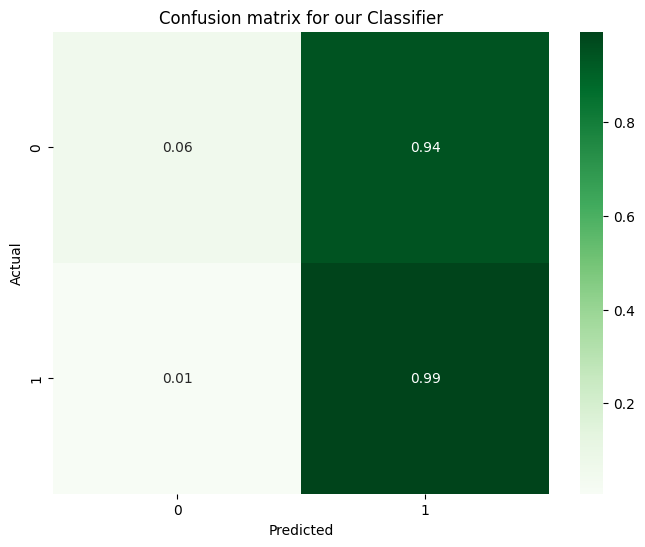

In [ ]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_test, y_pred, normalize='true')

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, cmap='Greens', fmt='.2f', 
            xticklabels=best_model.classes_, 
            yticklabels=best_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion matrix for our Classifier')
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_pred, y_test, digits=4))

              precision    recall  f1-score   support

           0     0.0565    0.6437    0.1038       174
           1     0.9927    0.8194    0.8978     10360

    accuracy                         0.8165     10534
   macro avg     0.5246    0.7315    0.5008     10534
weighted avg     0.9773    0.8165    0.8847     10534



In [ ]:
test[['Fault Group', 'Fault Specific']] = test['Fault'].str.split('-', expand=True)
test_selected = test[['Type','Priority','Zone','Speed Profile','ISP','Fault Group','Fault Specific']]
test_cleaned = test_selected.fillna("Missing")

columns_to_encode = ['Type','Priority','Zone','Speed Profile','ISP','Fault Specific','Fault Group']

one_hot_encoded_truckroll= encoder.transform(test_cleaned[columns_to_encode])
df_one_hot_encoded_truckroll = pd.DataFrame(one_hot_encoded_truckroll, columns=encoder.get_feature_names_out(columns_to_encode))
test_cleaned = pd.concat([test_cleaned.reset_index(drop=True), df_one_hot_encoded_truckroll.reset_index(drop=True)], axis=1)
test_cleaned.drop(columns=columns_to_encode, inplace=True)




In [ ]:
predictions = best_model.predict(test_cleaned)
print(predictions)
print("Accuracy Score:")
print(accuracy_score(predictions, test_result))

[1 1 1 ... 1 1 1]
Accuracy Score:
0.8172595578788818
